In [ ]:
!pip install gseapy==1.1.0

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as smm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from scipy.stats import ttest_ind,zscore

## 1.Perform PCA analysis. Plot the scatter plot with the first 2 PCs.

In [ ]:
# load and view data
thca_data = pd.read_csv('/content/cleaned_THCA.csv', index_col=0)
thca_data.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,pathology_M_stage,histological_type,number_of_lymph_nodes,gender,radiation_therapy,residual_tumor,race,ethnicity,overall_survival,status
TCGA.4C.A93U,6.7783,0.0000,0.0000,6.3423,0.5686,13.7067,8.0058,1.5521,0.0,9.3809,...,m0,thyroidpapillarycarcinoma-classical/usual,1,female,no,r0,blackorafricanamerican,nothispanicorlatino,129,0
TCGA.BJ.A0YZ,7.9814,0.5023,4.6288,6.0307,0.8742,14.3016,8.1656,2.7721,0.0,9.2836,...,m0,thyroidpapillarycarcinoma-classical/usual,0,male,no,r0,white,nothispanicorlatino,754,0
TCGA.BJ.A0Z0,7.1232,0.0000,2.4177,5.4087,1.3670,13.0320,7.1533,0.0000,0.0,9.1990,...,m0,thyroidpapillarycarcinoma-classical/usual,0,male,yes,r0,white,nothispanicorlatino,419,0
TCGA.BJ.A0Z2,8.4094,0.0000,4.7105,6.7106,0.0000,12.5317,7.0354,2.9358,0.0,9.5001,...,m1,thyroidpapillarycarcinoma-follicular(>=99%foll...,0,male,yes,r0,blackorafricanamerican,nothispanicorlatino,1514,0
TCGA.BJ.A0Z3,6.7996,0.0000,1.6286,6.5277,0.0000,13.2771,7.8769,0.3351,0.0,9.2804,...,m0,thyroidpapillarycarcinoma-classical/usual,0,female,yes,r0,white,nothispanicorlatino,497,0


In [ ]:
# split clinical and expression data
thca_expression = thca_data.iloc[:, 0:-15]
thca_clinical = thca_data.iloc[:, -15:]
# view
display(thca_clinical.head())
display(thca_expression.head())

In [ ]:
# ensure all data in expression are numeric
thca_expression = thca_expression.apply(pd.to_numeric)

### (1)Perform PCA

In [ ]:
# standardize and fit
scaler = StandardScaler()
exp_scaled = scaler.fit_transform(thca_expression)
pca = PCA(n_components=100)
pca_exp = pca.fit_transform(exp_scaled)

In [ ]:
pc_names = [f'PC{i+1}' for i in range(100)]
pca_df = pd.DataFrame(pca_exp, columns=pc_names)
pca_df.head()

### (2)Scatter plot for first two PCs

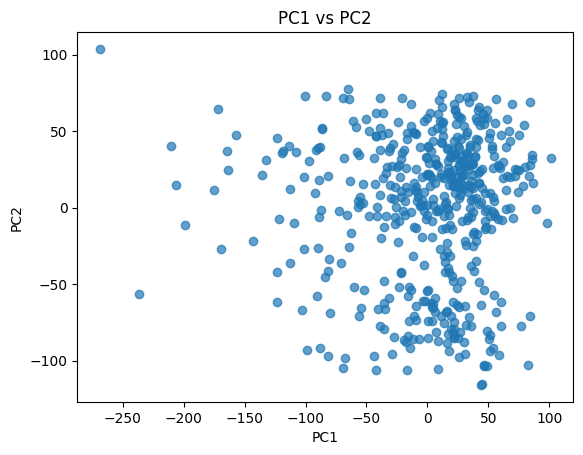

In [ ]:
# plot
plt.scatter(pca_exp[:, 0], pca_exp[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.show()

## 2.Determine the optimal cluster number with elbow plot or any equivalents

In [ ]:
sil_scores = []
K_range = range(2, 10)  # silhouette 不适用于 k=1

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=33, n_init='auto')
    kmeans.fit(pca_exp)
    labels = kmeans.labels_
    score = silhouette_score(pca_df, labels)
    sil_scores.append(score)

Text(0, 0.5, 'Silhouette Score')

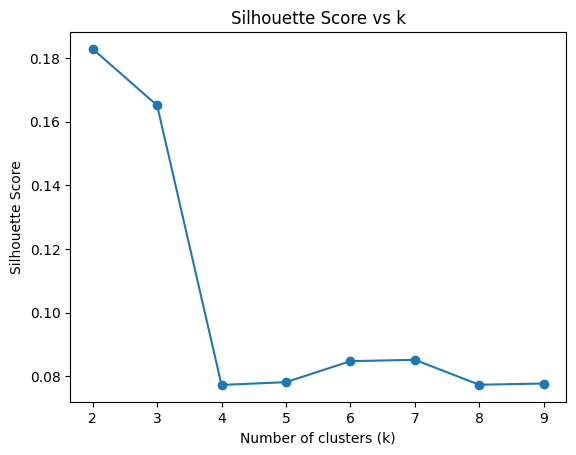

In [ ]:
# plot
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

## 3.Perform clustering analysis using the PC values generated from step. 1 and optimal cluster number in step 2.

In [ ]:
# choose the highest k=2
kmeans = KMeans(n_clusters=2, random_state=55, n_init='auto')
labels = kmeans.fit_predict(pca_exp)

<Axes: xlabel='PC1', ylabel='PC2'>

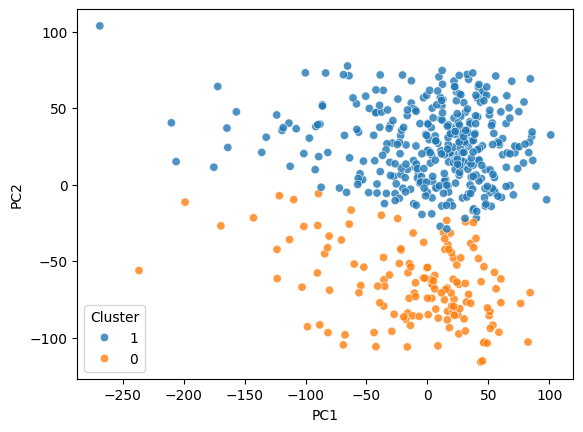

In [ ]:
# plot
pc_df = pd.DataFrame({
    'PC1': pca_exp[:, 0],
    'PC2': pca_exp[:, 1],
    'Cluster': labels.astype(str)
})
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.8)

In [ ]:
# save cluster data
thca_expression['cluster'] = labels

In [ ]:
thca_expression.head()

## 4.Perform the differential expression analysis and draw the volcano plot between 2 selected clusters

In [ ]:
# define groups
group1 = thca_expression[thca_expression['cluster'] == 0].index
group2 = thca_expression[thca_expression['cluster'] == 1].index
# drop cluster column
exp_data = thca_expression.drop(columns=['cluster'])
print('group1 length:', len(group1))
print('group2 length:', len(group2))

In [ ]:
def quantile_normalize(df):
    """
    Perform quantile normalization on a DataFrame.
    """
    # Step 1: Sort each column
    sorted_df = np.sort(df.values, axis=0)

    # Step 2: Compute the mean of each row across sorted columns
    mean_ranks = np.mean(sorted_df, axis=1)

    # Step 3: Assign mean ranks back to the original matrix
    ranks = np.argsort(np.argsort(df.values, axis=0), axis=0)  # Get ranks of original data
    normalized_data = np.zeros_like(df.values)

    for col in range(ranks.shape[1]):
        normalized_data[:, col] = mean_ranks[ranks[:, col]]

    # Convert back to DataFrame
    return pd.DataFrame(normalized_data, index=df.index, columns=df.columns)

In [ ]:
def z_score_transform(df):
    return df.apply(zscore, axis=0)

In [ ]:
Q_expression_data = quantile_normalize(exp_data)
z_expression_data = z_score_transform(Q_expression_data)

### (1) perform t-test

In [ ]:
# Perform t-tests for each individual gene.
p_values = []
for gene in tqdm(z_expression_data.columns):
    stat, p = ttest_ind(
        z_expression_data.loc[group1, gene],  # group1 data
        z_expression_data.loc[group2, gene],  # group2 data
        equal_var=True
    )
    p_values.append(p)

# Perform multiple testing correction
p_adjusted = smm.multipletests(p_values, method='fdr_bh')[1]

# Organize the statistical results into a DataFrame.
results = pd.DataFrame({
    'Gene': z_expression_data.columns,
    'p_value': p_values,
    'p_adjusted': p_adjusted
})

# log2FoldChange
group1_mean = np.array(exp_data.loc[group1].mean(axis=0))
group2_mean = np.array(exp_data.loc[group2].mean(axis=0))
results['log2FoldChange'] = np.log2(group1_mean)- np.log2(group2_mean)

# -log10(p_adjusted)
results['-log10(p_adjusted)'] = -np.log10(results['p_adjusted'])

In [ ]:
results

### (2) Generate volcano plot

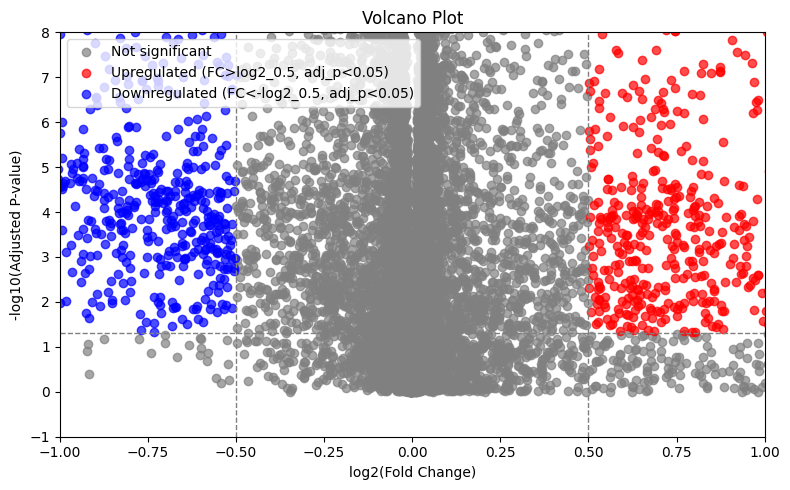

In [ ]:
plt.figure(figsize=(8, 5))

# Define thresholds
padj_threshold = 0.05
log2fc_threshold = 0.5

# get individual arrays/variables
log2fc = results.log2FoldChange
padj = results.p_adjusted
neg_log10_padj = -np.log10(padj)
fc_threshold_up = log2fc_threshold
fc_threshold_down = -log2fc_threshold

# Create masks for different categories
upregulated = (padj < padj_threshold) & (log2fc > log2fc_threshold)
downregulated = (padj < padj_threshold) & (log2fc < -log2fc_threshold)

# Plot each category separately
plt.scatter(log2fc[~(upregulated | downregulated)], neg_log10_padj[~(upregulated | downregulated)],
            color='gray', alpha=0.7, label='Not significant')
plt.scatter(log2fc[upregulated], neg_log10_padj[upregulated],
            color='red', alpha=0.7, label=f'Upregulated (FC>log2_{log2fc_threshold}, adj_p<{padj_threshold})')
plt.scatter(log2fc[downregulated], neg_log10_padj[downregulated],
            color='blue', alpha=0.7, label=f'Downregulated (FC<-log2_{log2fc_threshold}, adj_p<{padj_threshold})')

# Add reference lines
plt.axhline(-np.log10(0.05), color='grey', linestyle='--', linewidth=1)
plt.axvline(fc_threshold_up, color='grey', linestyle='--', linewidth=1)
plt.axvline(fc_threshold_down, color='grey', linestyle='--', linewidth=1)

# Set plot properties
plt.xlim(-1, 1)
plt.ylim(-1, 8)
plt.title("Volcano Plot")
plt.xlabel("log2(Fold Change)")
plt.ylabel("-log10(Adjusted P-value)")
plt.legend(loc='best')
plt.tight_layout()

plt.show()

### (3)Correlational analysis

In [ ]:
filtered_results = results[
    (np.abs(results['log2FoldChange']) > log2fc_threshold) &  # |log2FoldChange| > 0.2
    (results['-log10(p_adjusted)'] > -np.log10(padj_threshold))  # -log10(p_adjusted) > -log10(0.05)
]

# Sort the results in descending order based on -log10(p_adjusted).
filtered_results = filtered_results.sort_values(by='-log10(p_adjusted)', ascending=False)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


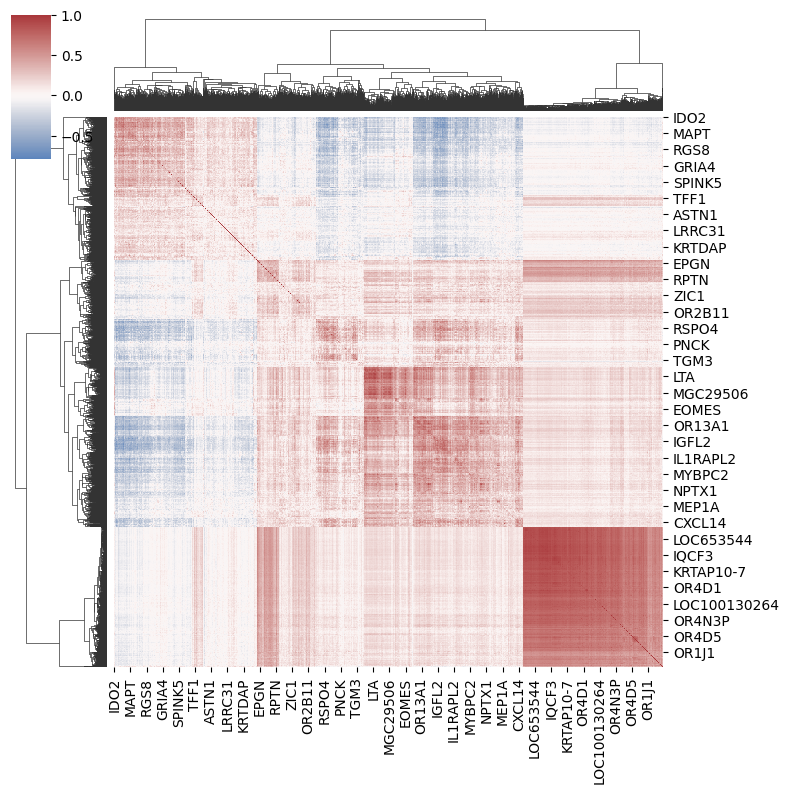

In [ ]:
DEG_list=list(filtered_results["Gene"])
DEG_expression_df = z_expression_data[DEG_list]

# Compute the correlation coefficient matrix.
correlation_matrix = DEG_expression_df.corr(method='pearson')

# draw the heatmap
sns.clustermap(correlation_matrix, figsize=(8, 8),annot=False, cmap="vlag", center=0,dendrogram_ratio=0.15)
plt.show()

## 5.Perform GO analysis of the significantly differentially expressed genes in the 2 clusters and draw the barplots

In [ ]:
# store up-regulated and down-regulated gene
down_DEG_list=list(filtered_results[filtered_results['log2FoldChange']<0]["Gene"])
up_DEG_list=list(filtered_results[filtered_results['log2FoldChange']>0]["Gene"])

In [ ]:
# GO analysis
go_up = gp.enrichr(up_DEG_list, organism='human',
          gene_sets=['GO_Biological_Process_2023',
          'GO_Molecular_Function_2023',
          'GO_Cellular_Component_2023'],
          outdir=None)
df_up = go_up.results
df_up = df_up[df_up["Adjusted P-value"]<0.05]

/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


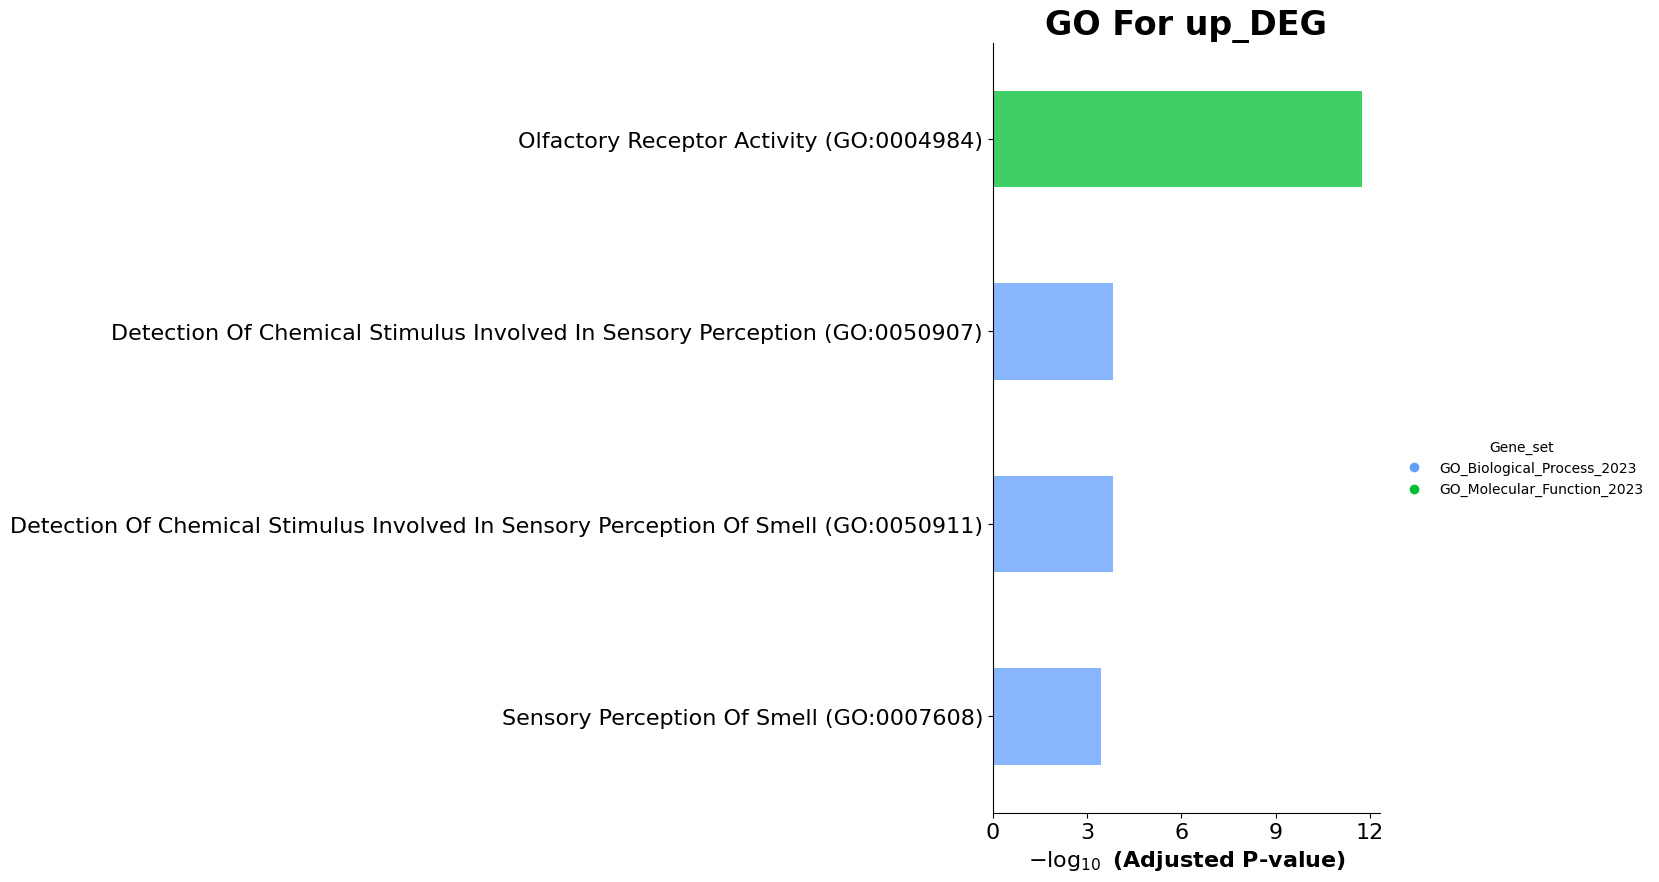

In [ ]:
# draw the barplot
ax=gp.barplot(df_up,
              title="GO For up_DEG",
              column="Adjusted P-value",
              group='Gene_set',
              top_term=10,
              figsize=(5,10),
              color={'GO_Biological_Process_2023':'#609efc','GO_Molecular_Function_2023':'#00bf32',\
                     'GO_Cellular_Component_2023':'#f9766c'},
              cutoff=0.05
              )

In [ ]:
go_down = gp.enrichr(down_DEG_list, organism='human',
                 gene_sets=['GO_Biological_Process_2023',
                            'GO_Molecular_Function_2023',
                            'GO_Cellular_Component_2023'],
                 outdir=None)
df_down = go_down.results
df_down = df_down[df_down["Adjusted P-value"]<0.05]

/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/usr/local/lib/python3.11/dist-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


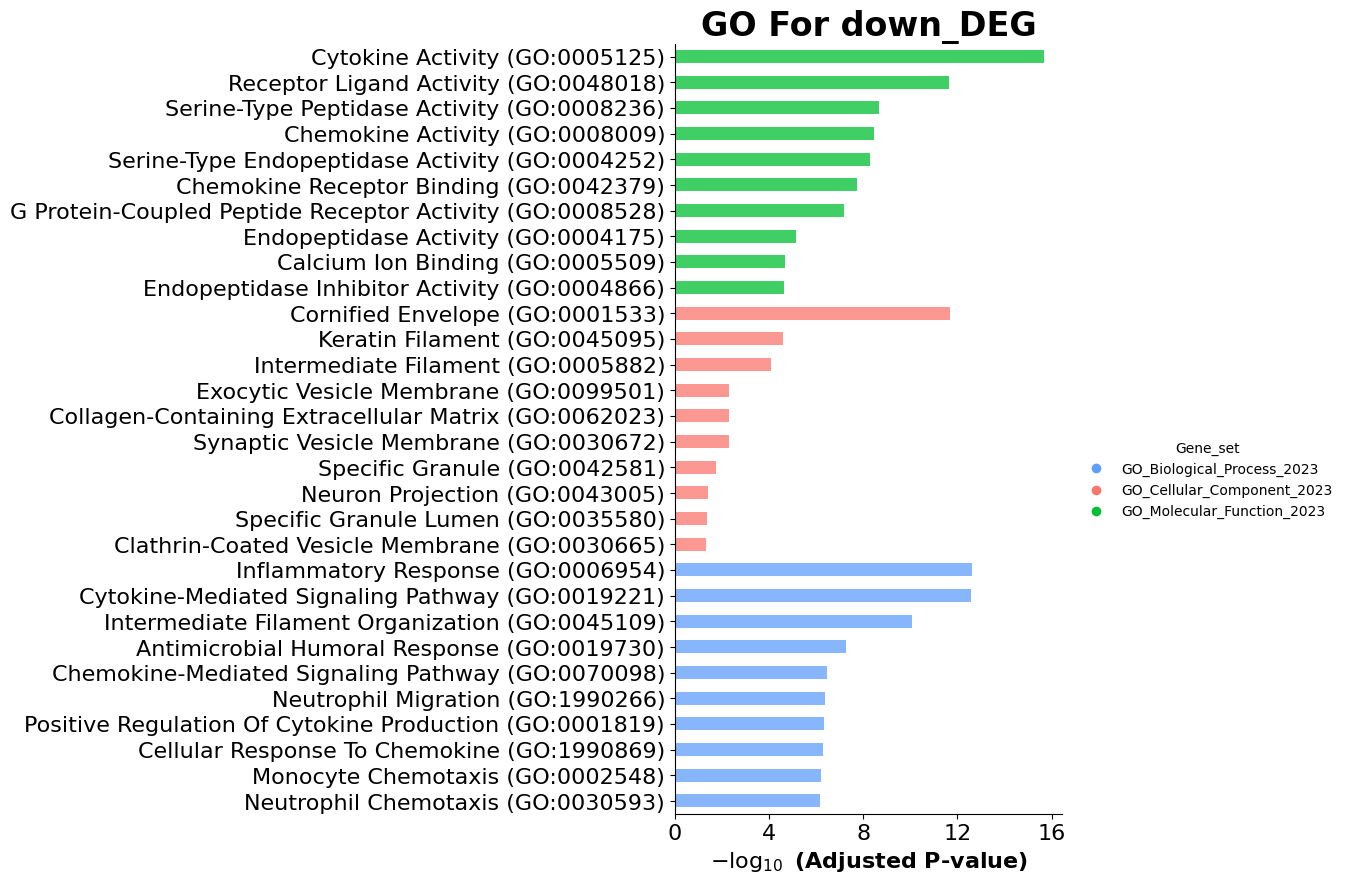

In [ ]:
ax=gp.barplot(df_down,
              title="GO For down_DEG",
              column="Adjusted P-value",
              group='Gene_set',
              top_term=10,
              figsize=(5,10),
              color={'GO_Biological_Process_2023':'#609efc','GO_Molecular_Function_2023':'#00bf32',\
                     'GO_Cellular_Component_2023':'#f9766c'},
              cutoff=0.05
              )